In [1]:
import os
import sys
sys.path.insert(0, os.path.dirname(os.getcwd()))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import scienceplots

from scipy import signal
from scipy.io import wavfile

from kode.utils.filter import *
from kode.data.datagen import HeartSoundDataGenerator

from kode.utils.sig_util import *

plt.rcParams.update({'figure.dpi': '80', 'savefig.format': 'pdf', 'text.usetex': True, 'font.family': 'serif', 'font.size': 12})

%config InlineBackend.figure_format = 'retina'

plt.style.use(['vibrant',])

_RD_SEED = 13
_DATASETS = ["bently", "cinc", "circor", "synthetic"]

class_info = []

np.random.seed(_RD_SEED)

#### Extracting Audio Data From The Datasets

In [4]:
def get_cls_labels(db, cls):
    map = None
    if db == "bently":
        map = {
            0: "Artifact",
            1: "Extrahs",
            2: "Extrasystole",
            3: "Murmur",
            4: "Normal",
        }
    elif db == "cinc" or db == "synthetic":
        map = {
            0: "Normal",
            1: "Murmur",
        }
    elif db == "circor":
        map = {
            0: "Normal",
            1: "Murmur",
            2: "Unknown",
        }
    
    return [map[i] for i in cls]

def get_db_name(db):
    map = {
        "bently": "Pascal",
        "cinc": "CinC",
        "synthetic": "Synthetic",
        "circor": "CirCor",
    }
    return map[db]


In [5]:
for i in range(len(_DATASETS)):
    dataset = _DATASETS[i]
    ds_dir = f"dataset/{dataset}"
    generator = HeartSoundDataGenerator(dataset, ds_dir)
    data = generator.get_data()

    y_tmp = np.array(data[1])

    cls, counts = np.unique(y_tmp, return_counts=True)

    labels = get_cls_labels(dataset, cls)
    db_name = get_db_name(dataset)

    sorted_labels_counts = sorted(zip(labels, counts))
    labels, counts = zip(*sorted_labels_counts)

    info = {"db": db_name, "labels": labels, "counts": counts}

    class_info.append(info)

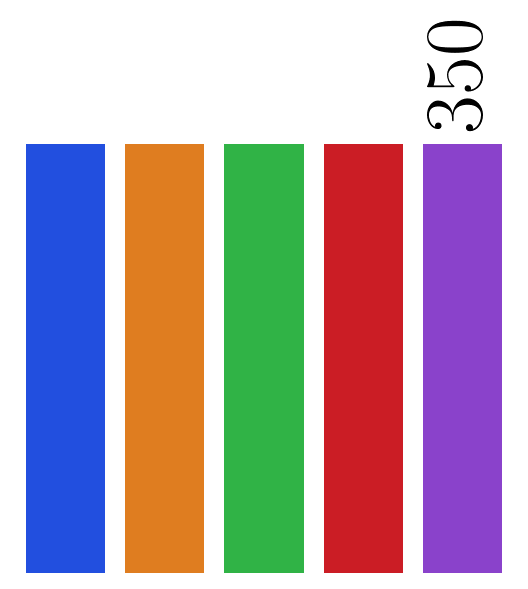

In [6]:
from kode.utils.plot import bar

X = ["Artifact", "Extrahs", "Extrasystole", "Murmur", "Normal"]

y1 = [40, 19, 46, 127, 350]
y2 = [350, 350, 350, 350, 350]

palette = "bright"

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

bar(X=X, y=y2, title=None, ax=ax, pal=palette, sd=1)

ax.set_axis_off()

plt.savefig("class2_dist_no_.pdf", format="pdf", dpi=800)

#### Plotting `Class Distribution` of All The Datasets

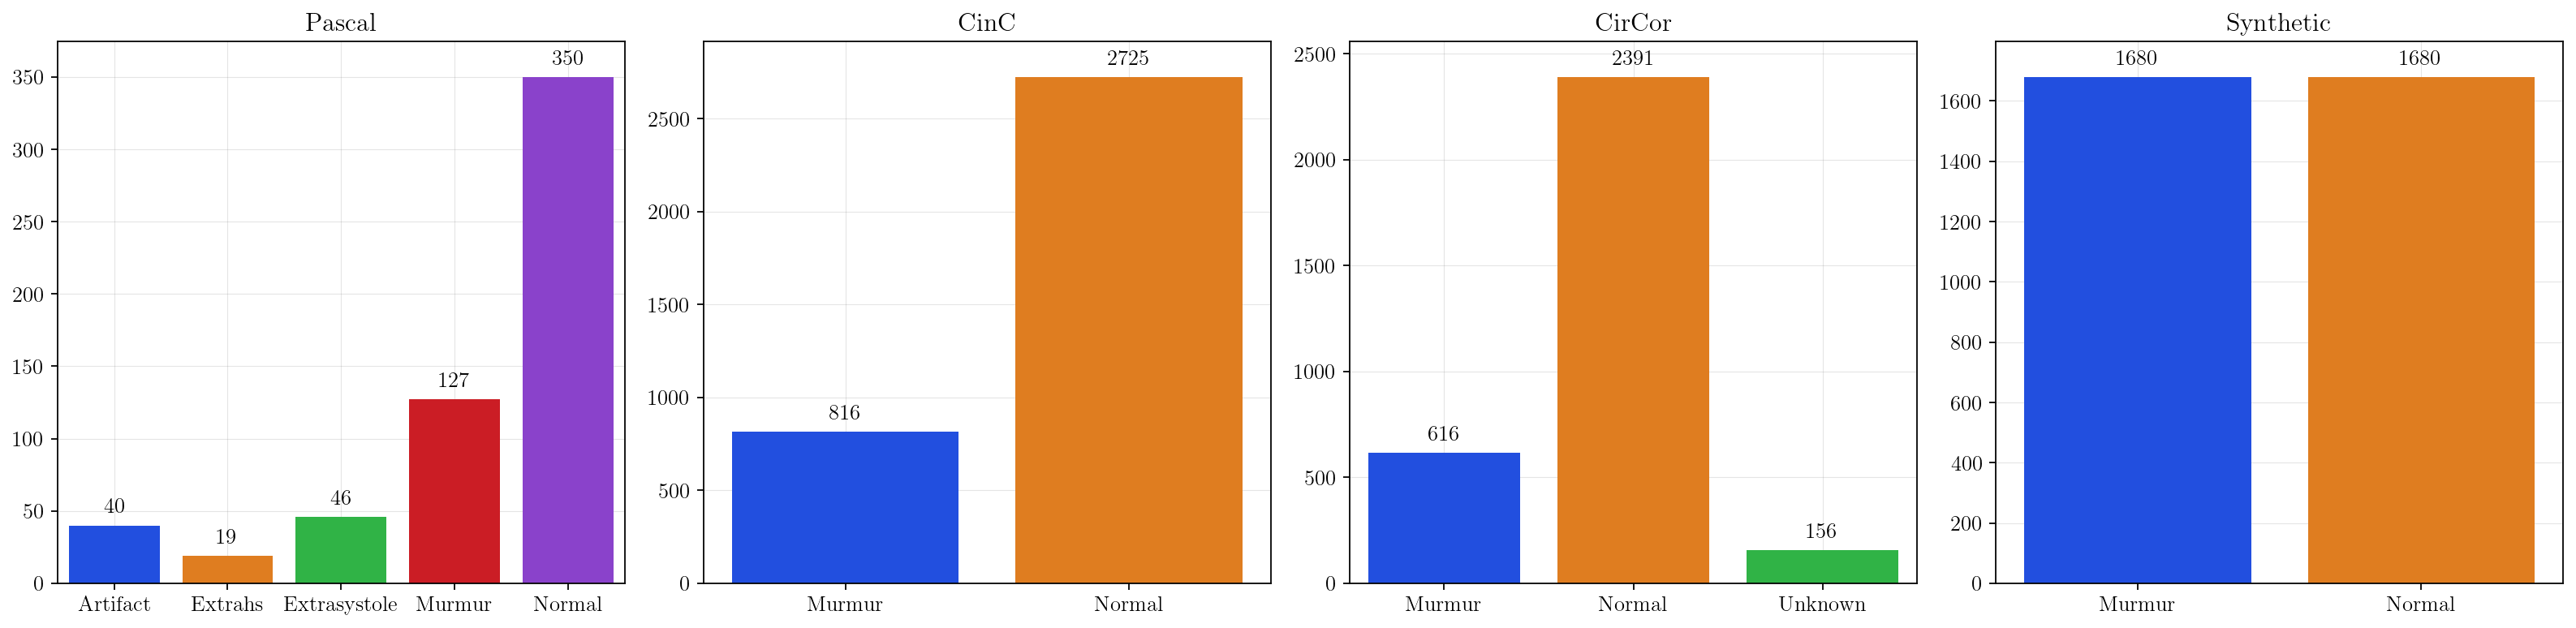

In [10]:
from kode.utils.plot import bar

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
palette = "bright"

info_1 = class_info[0]
bar(X=info_1["labels"], y=info_1["counts"], title=info_1["db"], ax=ax[0], pal=palette, sd=_RD_SEED)

info_2 = class_info[1]
bar(X=info_2["labels"], y=info_2["counts"], title=info_2["db"], ax=ax[1], pal=palette, sd=_RD_SEED)

info_3 = class_info[2]
bar(X=info_3["labels"], y=info_3["counts"], title=info_3["db"], ax=ax[2], pal=palette, sd=_RD_SEED)

info_4 = class_info[3]
bar(X=info_4["labels"], y=info_4["counts"], title=info_4["db"], ax=ax[3], pal=palette, sd=_RD_SEED)

plt.tight_layout()
plt.show()

fig.savefig("paper/graphics/cls_dist.pdf", format="pdf", dpi=800)

#### Plotting Raw Audio Data `With` and `Without` Outliers

In [23]:
dataset = _DATASETS[0]
ds_dir = f"dataset/{dataset}"
generator = HeartSoundDataGenerator(dataset, ds_dir)
X, y = generator.get_data()

X = np.array(X)
y = np.array(y)

sample = X[np.random.randint(0, len(X))]

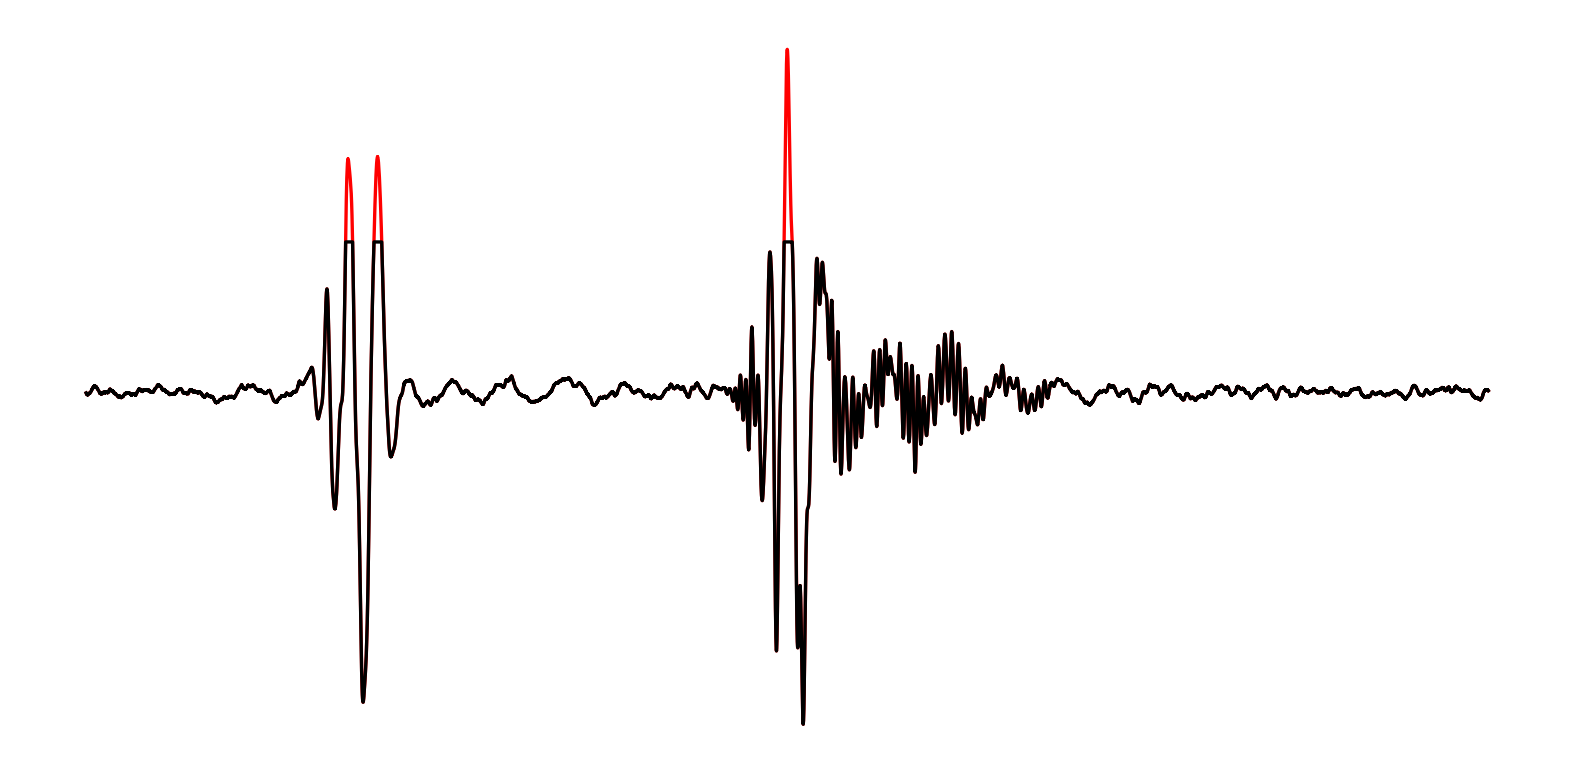

In [28]:
fs, audio = wavfile.read(sample)
audio = np.float64(audio)
np.divide(audio, np.float64(32768), out=audio)
aud_len = audio.shape[0] / fs
time = np.linspace(0, aud_len, audio.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.grid(linewidth=0.5, color="gray", alpha=0.2)

sns.lineplot(x=time, y=audio, color="red")

audio = remove_outliers(audio, 3)

sns.lineplot(x=time, y=audio, color="black")

ax.set_xlabel("Time (s)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)


plt.tight_layout()
plt.show()

fig.savefig("paper/graphics/audio_n_outliers.pdf", format="pdf", dpi=800)

In [ ]:
from kode.utils.filter import bp_butter_filter

fs = 1000
lowcut = 20
highcut = 500

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.grid(linewidth=0.5, color="gray", alpha=0.2)

sns.lineplot(x=time, y=audio, color="red")

audio_f = bp_butter_filter(audio, fs, 2, highcut, lowcut,)

sns.lineplot(x=time, y=audio_f, color="black")

ax.set_xlabel("Time (s)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)

plt.tight_layout()
plt.show()

fig.savefig("paper/graphics/audio_n_bwf.pdf", format="pdf", dpi=800)

#### Plotting Distribution Plot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2)

sns.histplot(audio, color="black", kde=True, ax=axs[0])
axs[0].set_title("Before filtering the noisy signal")

sns.histplot(audio_f, color="darkblue", kde=True, ax=axs[1])
axs[1].set_title("After filtering the noisy signal")

axs[0].set_xlabel("Amplitude")
axs[0].set_ylabel("Count")

axs[1].set_xlabel("Amplitude")
axs[1].set_ylabel("Count")

axs[0].grid(linewidth=0.5, color="gray", alpha=0.2)
axs[1].grid(linewidth=0.5, color="gray", alpha=0.2)

axs[0].set_axisbelow(True)
axs[1].set_axisbelow(True)

plt.tight_layout()
plt.show()

fig.savefig("paper/graphics/audio_n_bwf_hist.pdf", format="pdf", dpi=800)

In [ ]:
M = 100
s = 25.0
w = 10.0
wavelet = signal.morlet2(M, s, w)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plt.grid(linewidth=0.5, color="gray", alpha=0.2)
sns.lineplot(wavelet.real, label="Real")
sns.lineplot(wavelet.imag, label="Imaginary")

plt.tight_layout()
plt.legend()
plt.show()

fig.savefig("paper/graphics/morlet.pdf", format="pdf", dpi=600)

### Heart sound

In [5]:
dataset = _DATASETS[0]
ds_dir = f"dataset/{dataset}"
generator = HeartSoundDataGenerator(dataset, ds_dir)
data = generator.get_data()

audio_data = np.array(data[0])
label_data = np.array(data[1]).astype(np.float32)

In [5]:
def draw_hline(ax, mid_y, pos_start, pos_end, text):
    ax.annotate('', xy=(pos_start, mid_y), xytext=(pos_end, mid_y), arrowprops=dict(arrowstyle='<->'))
    ax.text((pos_start + pos_end) / 2, mid_y + 300, text, ha='center', va='bottom', fontsize=16)

In [6]:
_, sig = wavfile.read(audio_data[70])
_, sig2 = wavfile.read(audio_data[94])

In [ ]:
sig = sig[:50000]

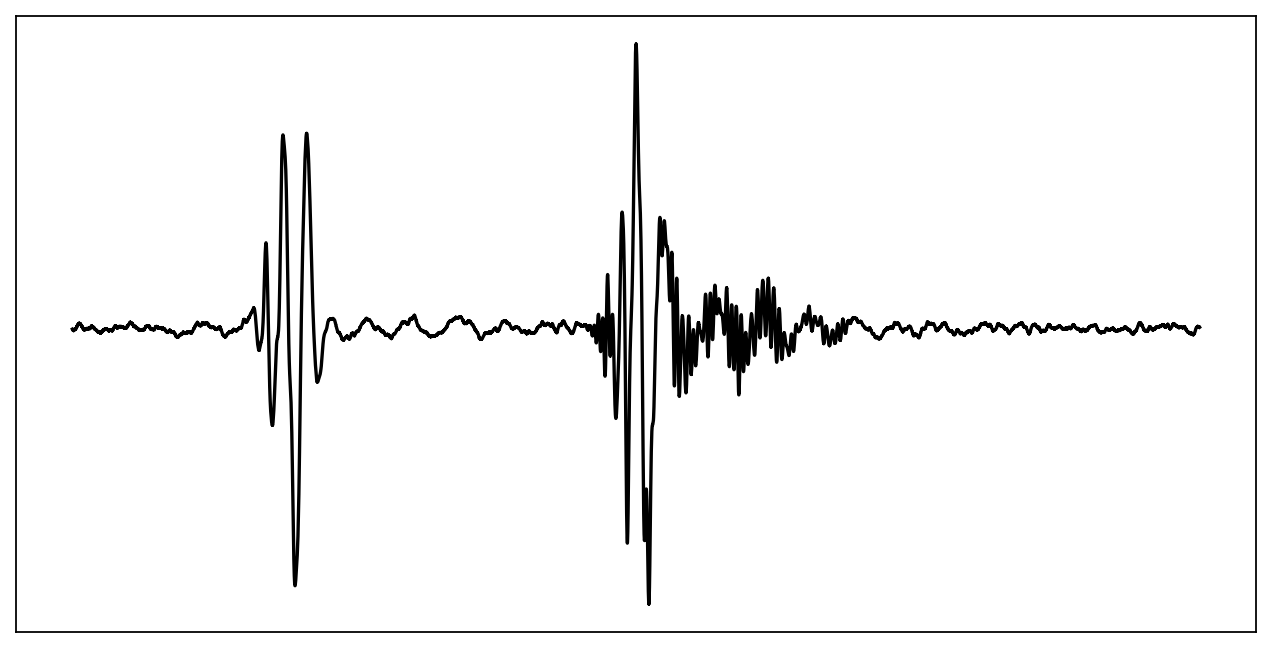

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.set_xticks([])
ax.set_yticks([])
# ax.set_axis_off()
ax.grid(linewidth=0.5, color="gray", alpha=0.2)

plt.plot(sig, color="black")

plt.savefig("sig_axis.pdf", format="pdf", dpi=800)

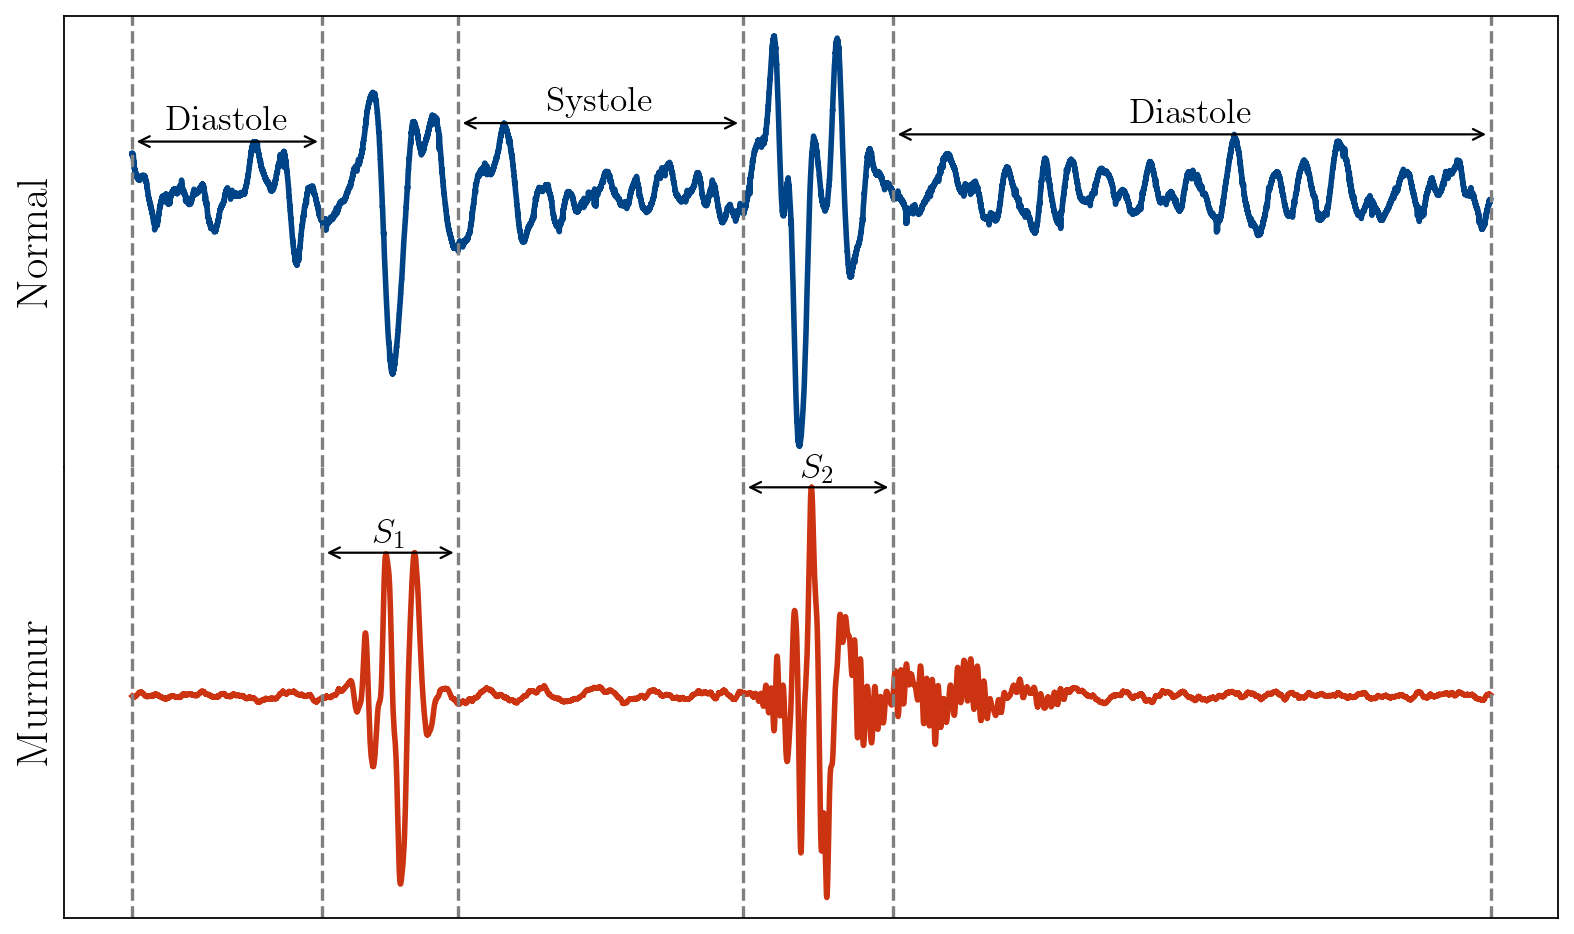

In [6]:
_, sig = wavfile.read(audio_data[70])
_, sig2 = wavfile.read(audio_data[94])

sig = sig[:50000]
sig2 = sig2[10500:50000]

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

axes[0].plot(sig2, color="#004488", lw=2.5)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_ylabel("Normal", fontsize=20)

for spine in ['bottom',]:
    axes[0].spines[spine].set_visible(False)

vlines_positions = [0, 5530, 9480, 17750, 22130, 39500]
for pos in vlines_positions:
    axes[0].axvline(x=pos, color='gray', linestyle='--')

i = 0
mid_y = max(sig2[vlines_positions[i]:vlines_positions[i+1]])
draw_hline(axes[0], mid_y, vlines_positions[i], vlines_positions[i+1], "Diastole")

i = 2
mid_y = max(sig2[vlines_positions[i]:vlines_positions[i+1]])
draw_hline(axes[0], mid_y, vlines_positions[i], vlines_positions[i+1], "Systole")

i = 4
mid_y = max(sig2[vlines_positions[i]:vlines_positions[i+1]])
draw_hline(axes[0], mid_y, vlines_positions[i], vlines_positions[i+1], "Diastole")

axes[1].plot(sig, color="#cc3311", lw=2.5)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_ylabel("Murmur", fontsize=20)

for spine in ['top']:
    axes[1].spines[spine].set_visible(False)

vlines_positions = [0, 7000, 12000, 22500, 28000, 50000]
for pos in vlines_positions:
    axes[1].axvline(x=pos, color='gray', linestyle='--')

i = 1
mid_y = max(sig[vlines_positions[i]:vlines_positions[i+1]])
draw_hline(axes[1], mid_y, vlines_positions[i], vlines_positions[i+1], "$S_1$")

i = 3
mid_y = max(sig[vlines_positions[i]:vlines_positions[i+1]])
draw_hline(axes[1], mid_y, vlines_positions[i], vlines_positions[i+1], "$S_2$")

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()

fig.savefig("paper/graphics/heart_patterns.pdf", format="pdf", dpi=600)

### Heart Sounf of Different Classes

In [7]:
dataset_b = _DATASETS[0]
dataset_c = _DATASETS[2]

ds_dir_b = f"dataset/{dataset_b}"
ds_dir_c = f"dataset/{dataset_c}"

generator_b = HeartSoundDataGenerator(dataset_b, ds_dir_b)
generator_c = HeartSoundDataGenerator(dataset_c, ds_dir_c)

data_b = generator_b.get_data()
data_c = generator_c.get_data()

audio_data_b = np.array(data_b[0])
audio_data_c = np.array(data_c[0])

label_data_b = np.array(data_b[1]).astype(np.float32)
label_data_c = np.array(data_c[1]).astype(np.float32)

_, normal = wavfile.read(audio_data_b[102])
_, murmur = wavfile.read(audio_data_b[85])
_, artifact = wavfile.read(audio_data_b[10])
_, extrahs = wavfile.read(audio_data_b[51])
_, extrasystole = wavfile.read(audio_data_b[136])
_, unknown = wavfile.read(audio_data_c[10])

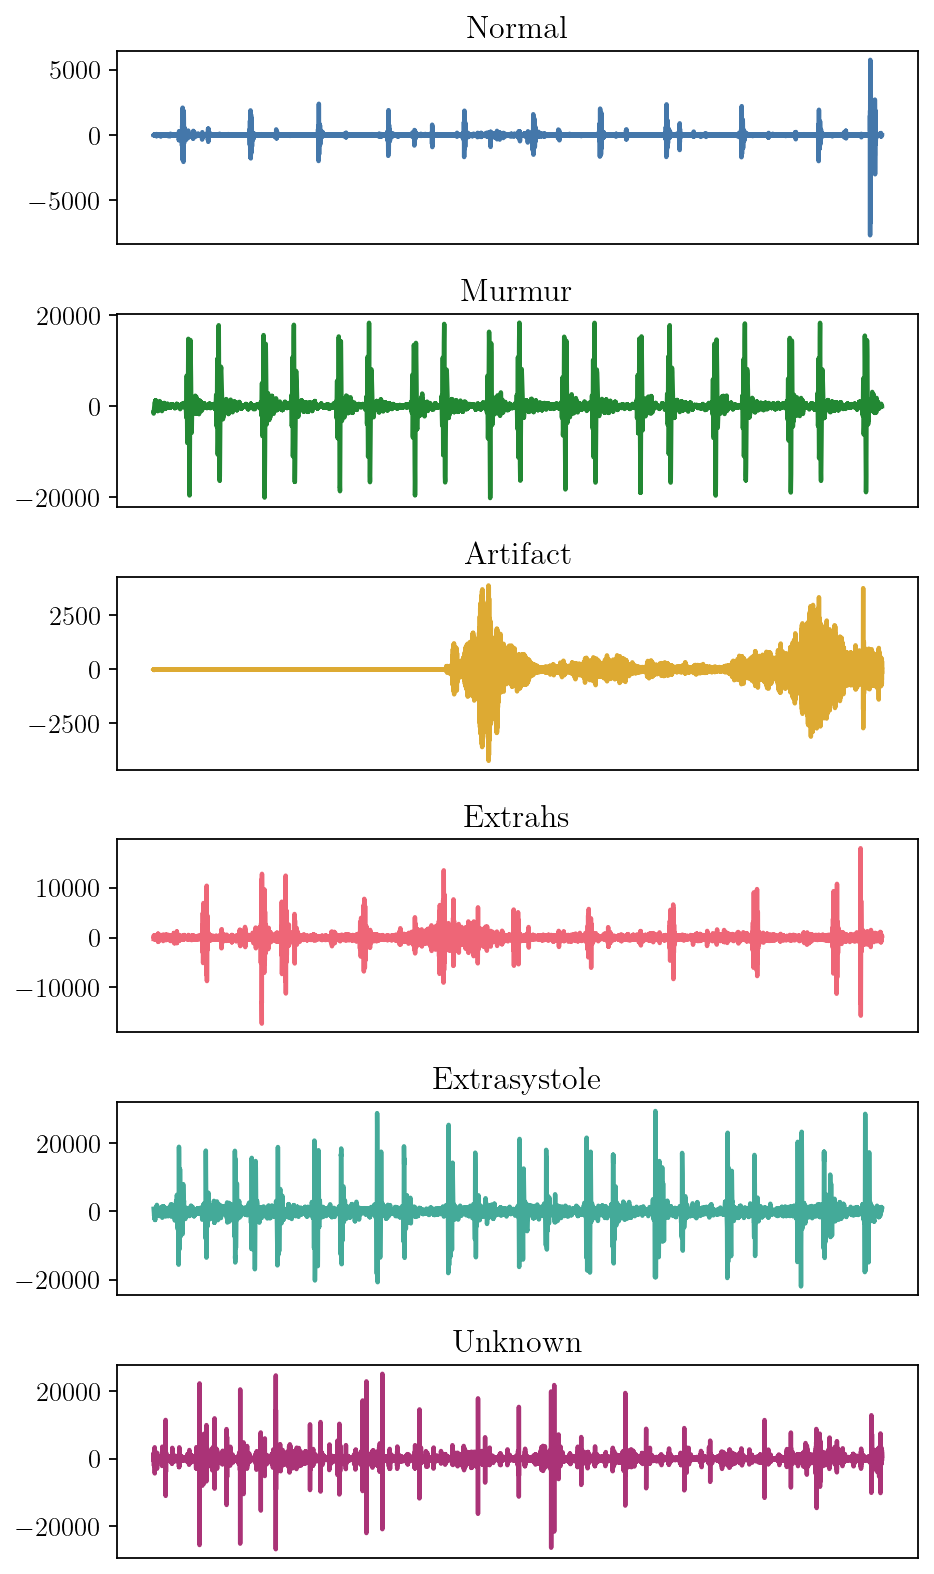

In [21]:
fig, axes = plt.subplots(6, figsize=(6, 10))
axes[0].plot(normal, color="#4477aa", lw=2)
axes[0].set_title("Normal")
axes[0].set_xticks([])

axes[1].plot(murmur, color="#228833", lw=2)
axes[1].set_title("Murmur")
axes[1].set_xticks([])

axes[2].plot(artifact, color="#ddaa33", lw=2)
axes[2].set_title("Artifact")
axes[2].set_xticks([])

axes[3].plot(extrahs, color="#ee6677", lw=2)
axes[3].set_title("Extrahs")
axes[3].set_xticks([])

axes[4].plot(extrasystole, color="#44aa99", lw=2)
axes[4].set_title("Extrasystole")
axes[4].set_xticks([])

axes[5].plot(unknown, color="#aa3377", lw=2)
axes[5].set_title("Unknown")
axes[5].set_xticks([])

plt.tight_layout()
plt.show()

fig.savefig("paper/graphics/sound_class.pdf", format="pdf", dpi=800)

#### Plotting Accuracy Plot

In [6]:
PATH_ROOT = "callbacks"
PAPER_PATH = "paper"
BENTLY = f"{PATH_ROOT}/Param_5453/{_DATASETS[0]}/training_logs.csv"
CINC = f"{PATH_ROOT}/Param_5453/{_DATASETS[1]}/training_logs.csv"
CIRCOR = f"{PATH_ROOT}/Param_5453/{_DATASETS[2]}/training_logs.csv"
SYNTHETIC = f"{PATH_ROOT}/Param_5453/{_DATASETS[3]}/training_logs.csv"

bently = np.loadtxt(BENTLY, delimiter=",", skiprows=1)
bently_train_acc = bently[:, 1] * 100
bently_val_acc = bently[:, 3] * 100
bently_train_loss = bently[:, 2] * 100
bently_val_loss = bently[:, 4] * 100

cinc = np.loadtxt(CINC, delimiter=",", skiprows=1)
cinc_train_acc = cinc[:, 1] * 100
cinc_val_acc = cinc[:, 3] * 100
cinc_train_loss = cinc[:, 2] * 100
cinc_val_loss = cinc[:, 4] * 100

circor = np.loadtxt(CIRCOR, delimiter=",", skiprows=1)
circor_train_acc = circor[:, 1] * 100
circor_val_acc = circor[:, 3] * 100
circor_train_loss = circor[:, 2] * 100
circor_val_loss = circor[:, 4] * 100

synthetic = np.loadtxt(SYNTHETIC, delimiter=",", skiprows=1)
synthetic_train_acc = synthetic[:, 1] * 100
synthetic_val_acc = synthetic[:, 3] * 100
synthetic_train_loss = synthetic[:, 2] * 100
synthetic_val_loss = synthetic[:, 4] * 100

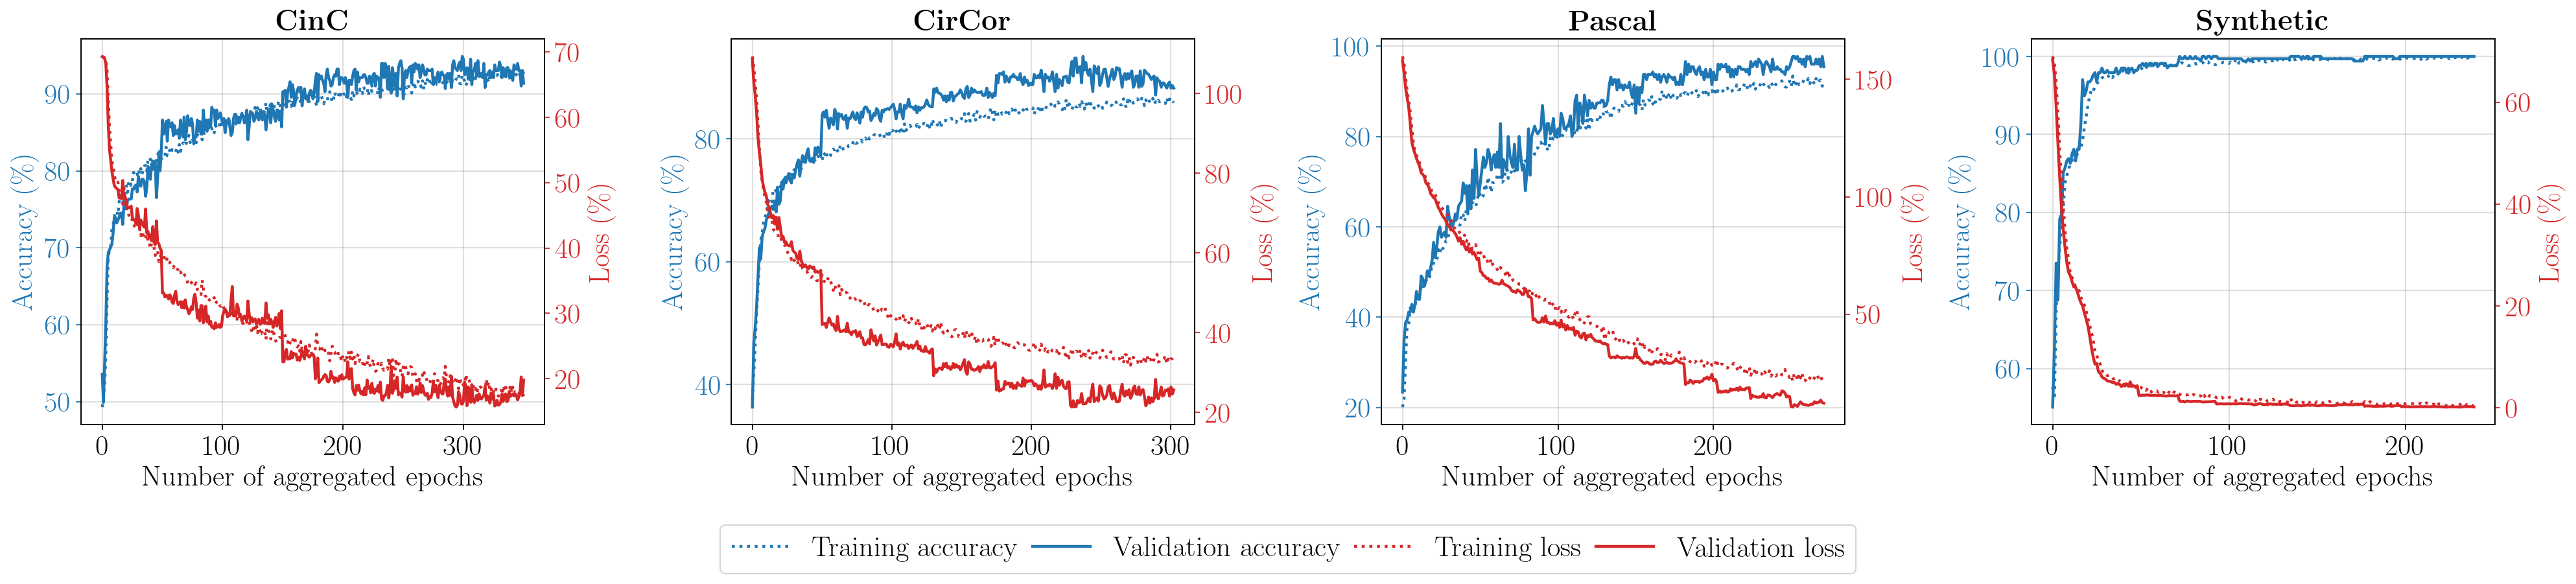

In [34]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(25, 5))

datasets = [
    (cinc_train_acc, cinc_val_acc, cinc_train_loss, cinc_val_loss, "CinC"),
    (circor_train_acc, circor_val_acc, circor_train_loss, circor_val_loss, "CirCor"),
    (bently_train_acc, bently_val_acc, bently_train_loss, bently_val_loss, "Pascal"),
    (
        synthetic_train_acc,
        synthetic_val_acc,
        synthetic_train_loss,
        synthetic_val_loss,
        "Synthetic",
    ),
]

ACC_COLOR = "tab:blue"
LOSS_COLOR = "tab:red"
lw = 2

lines_labels = []

for i, (train_acc, val_acc, train_loss, val_loss, title) in enumerate(datasets):
    ax1 = axs[i]
    ax1.set_axisbelow(True)
    line1, = ax1.plot(train_acc, linewidth=lw, ls=":", color=ACC_COLOR)
    line2, = ax1.plot(val_acc, linewidth=lw, color=ACC_COLOR)
    ax1.set_title(r"$\textbf{" + title + "}$", fontsize=20)
    ax1.tick_params(axis="y", colors=ACC_COLOR, labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_ylabel("Accuracy (\%)", color=ACC_COLOR, fontsize=20)
    ax1.set_xlabel("Number of aggregated epochs", fontsize=20)

    ax2 = ax1.twinx()
    line3, = ax2.plot(train_loss, linewidth=lw, ls=":", color=LOSS_COLOR)
    line4, = ax2.plot(val_loss, linewidth=lw, color=LOSS_COLOR)
    ax2.tick_params(axis="y", colors=LOSS_COLOR, labelsize=20)
    ax2.set_ylabel("Loss (\%)", color=LOSS_COLOR, fontsize=20)

    ax1.grid(linewidth=1, color="gray", alpha=0.25)

    if i == 0:
        lines_labels.extend([(line1, 'Training accuracy'), (line2, 'Validation accuracy'), 
                             (line3, 'Training loss'), (line4, 'Validation loss')])

fig.tight_layout()

lines, labels = zip(*lines_labels)
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.0005), ncol=4, columnspacing=0.5, fontsize=20)

plt.show()

fig.savefig("paper/graphics/train_val_curve.pdf", format="pdf", dpi=800, bbox_inches="tight", pad_inches=0.1)

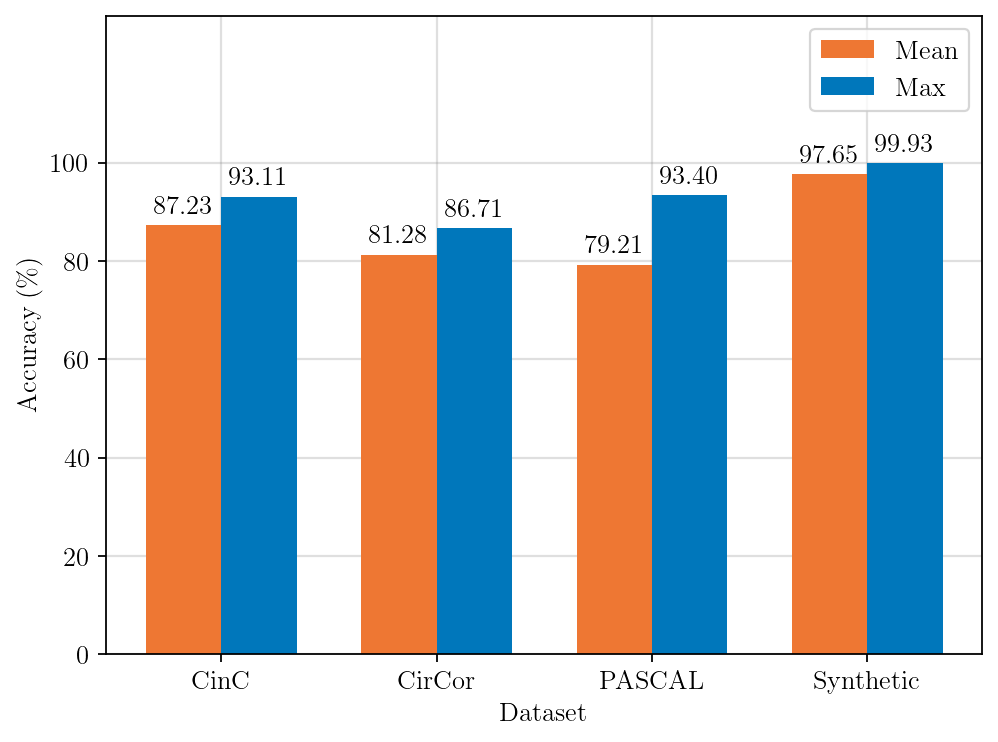

In [47]:
datasets = [cinc_train_acc, circor_train_acc, bently_train_acc, synthetic_train_acc]

mean_accuracies = [np.mean(d) for d in datasets]
max_accuracies = [np.max(d) for d in datasets]

fig, ax = plt.subplots()

ax.set_axisbelow(True)

bar_width = 0.35

index = np.arange(len(datasets))

rects1 = ax.bar(index, mean_accuracies, bar_width, label='Mean')
rects2 = ax.bar(index + bar_width, max_accuracies, bar_width, label='Max')

ax.set_xlabel('Dataset')
ax.set_ylabel('Accuracy (\%)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['CinC', 'CirCor', 'PASCAL', 'Synthetic'])
ax.legend()

ax.set_ylim(0, max(max_accuracies)*1.3)
yticks = np.arange(0, 101, 20)
ax.set_yticks(yticks)

for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.grid(linewidth=1, color="gray", alpha=0.25)
plt.tight_layout()
plt.show()

fig.savefig(
    "/home/jobayer/Research/Heart-Sound-Classifier/paper/graphics/train_min_max.pdf",
    dpi=600,
    format="pdf",
    bbox_inches="tight",
    bbox_extra_artists=[ax],
    pad_inches=0.0,
    transparent=True,
)

In [ ]:
datasets = [cinc_val_acc, circor_val_acc, bently_val_acc, synthetic_val_acc]

mean_accuracies = [np.mean(d) for d in datasets]
max_accuracies = [np.max(d) for d in datasets]

fig, ax = plt.subplots()
ax.set_axisbelow(True)

bar_width = 0.35

index = np.arange(len(datasets))

rects1 = ax.bar(index, mean_accuracies, bar_width, label='Mean')
rects2 = ax.bar(index + bar_width, max_accuracies, bar_width, label='Max')

ax.set_xlabel('Dataset')
ax.set_ylabel('Accuracy (\%)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['CinC', 'CirCor', 'PASCAL', 'Synthetic'])
ax.legend()

ax.set_ylim(0, max(max_accuracies)*1.3)
yticks = np.arange(0, 101, 20)
ax.set_yticks(yticks)

for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.grid(linewidth=1, color="gray", alpha=0.25)
plt.tight_layout()
plt.show()

fig.savefig(
    "/home/jobayer/Research/Heart-Sound-Classifier/paper/graphics/val_min_max.pdf",
    dpi=600,
    format="pdf",
    bbox_inches="tight",
    bbox_extra_artists=[ax],
    pad_inches=0.0,
    transparent=True,
)

#### Morlet Wavelet

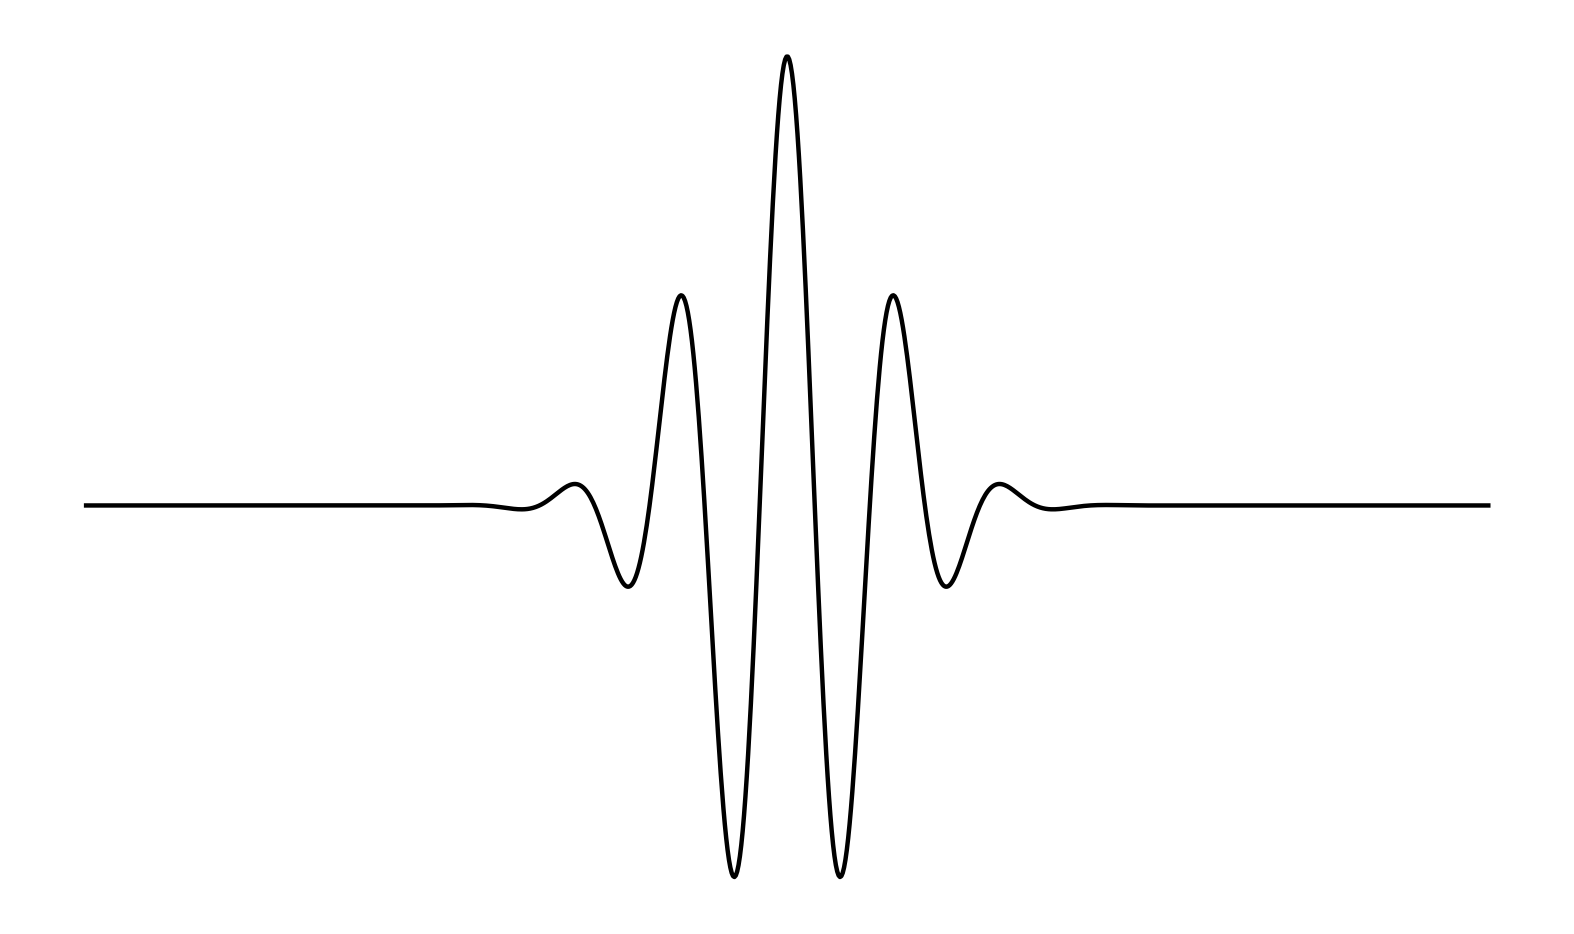

In [34]:
import pywt
import matplotlib.pyplot as plt

wavelet = pywt.ContinuousWavelet('morl')
psi, x = wavelet.wavefun(level=10)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_axis_off()

plt.plot(x, psi, linewidth=2, color="black")

plt.grid(linewidth=1, color="gray", alpha=0.25)
plt.tight_layout()
plt.show()

fig.savefig("morlet_no_axis.pdf", format="pdf", dpi=800)

# ax.savefig("morlet_no_axis.pdf=", format="pdf", dpi=800)

# fig.savefig(
#     "paper/graphics/morlet.pdf",
#     dpi=600,
#     format="pdf",
#     bbox_inches="tight",
#     bbox_extra_artists=[ax],
#     pad_inches=0.0,
#     transparent=True,
# )